In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
measurement_columns = inspector.get_columns("measurement")
station_columns = inspector.get_columns("station")
print("measurements")
for i in measurement_columns:
    print(i["name"], i["type"])
print("station")
for i in station_columns:
    print(i["name"], i["type"])

measurements
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date.date)

2017-08-23


([<matplotlib.axis.XTick at 0x1fda276e790>,
 [Text(0.0, 0, '2016-08-23'),
  Text(39.0, 0, '2016-10-01'),
  Text(78.0, 0, '2016-11-09'),
  Text(118.0, 0, '2016-12-19'),
  Text(158.0, 0, '2017-01-28'),
  Text(198.0, 0, '2017-03-09'),
  Text(238.0, 0, '2017-04-18'),
  Text(281.0, 0, '2017-05-31'),
  Text(321.0, 0, '2017-07-10')])

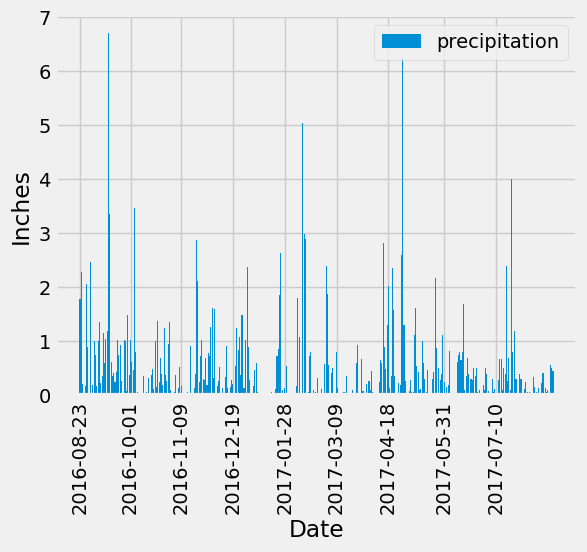

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
earliest_date = dt.datetime(int(latest_date[0][0:4])-1,int(latest_date[0][5:7]),int(latest_date[0][8:])).strftime("%Y-%m-%d")


#e_date = (dt.datetime.strptime(latest_date[0],"%Y-%m-%d") - dt.timedelta(days=365)).strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= earliest_date).all()

df = pd.DataFrame(results, columns = ['date', 'precipitation']).sort_values('date')

# Sort the dataframe by date

plt.bar(df["date"],df["precipitation"], label="precipitation")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(loc="upper right")
plt.tight_layout()
plt.xticks(["2016-08-23","2016-10-01","2016-11-09","2016-12-19","2017-01-28","2017-03-09","2017-04-18","2017-05-31","2017-07-10"], rotation="vertical")
# Use Pandas Plotting with Matplotlib to plot the data


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_stats = df.describe()["precipitation"]
precip_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
for i in activity:
    print(i)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
hightest_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
hightest_activity

avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == hightest_activity.station)

lowest = session.query(func.min(Measurement.tobs)).filter(Measurement.station == hightest_activity.station)

highest = session.query(func.max(Measurement.tobs)).filter(Measurement.station == hightest_activity.station)

print(f"The lowest temperature was: {lowest[0][0]} degrees F, the highest temperature was: {highest[0][0]} degrees F, and the average temperature was: {avg[0][0]} degrees F")

The lowest temperature was: 54.0 degrees F, the highest temperature was: 85.0 degrees F, and the average temperature was: 71.66378066378067 degrees F


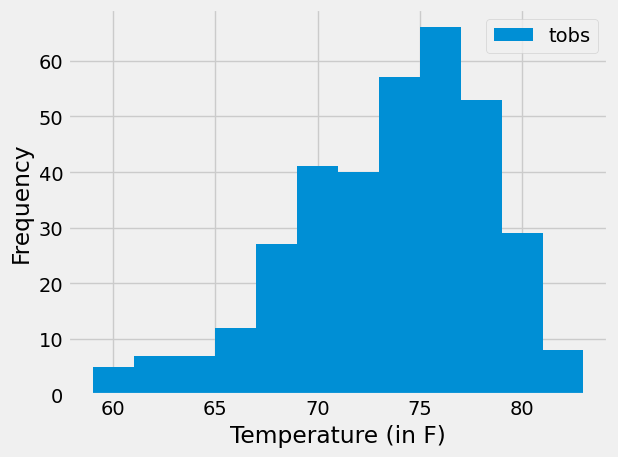

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
past_year = session.query(Measurement.tobs, func.count(Measurement.tobs)).filter(Measurement.station == hightest_activity.station).filter(Measurement.date >= earliest_date).group_by(Measurement.date).order_by(Measurement.tobs)



df2 = pd.DataFrame(past_year,columns = ["temp","frequency"])
df2["temp"] = df2["temp"].astype(int)

plt.hist(df2["temp"],bins=12, label="tobs")
plt.xlabel("Temperature (in F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.legend(loc="upper right")

# Close Session

In [18]:
# Close Session
session.close()